In [2]:
from __future__ import annotations

from collections import Counter, defaultdict
from dataclasses import dataclass
import functools
import random

# Moves and States of the game

In [3]:
@dataclass
class Move:
  """A move in a hexapawn game.
  """
  src: tuple[int]  # row, col
  dst: tuple[int]  # row, col

  def __hash__(self):
    return hash(self.src) ^ hash(self.dst)

  @staticmethod
  def parse(move: str) -> Move:
    """Convert a string like 'a1 a2' to a move.
    """
    src, dst = move.split(' ')
    return Move(Move._parseloc(src), Move._parseloc(dst))

  @staticmethod
  def _parseloc(loc: str) -> tuple[int]:
    """Convert something like b2 to a pair of ints.
    """
    file, rank = loc[0], loc[1]
    return 3 - int(rank), ord(file) - ord('a')

  def __str__(self) -> str:
    """Return a parseable string."""
    col_map = 'abc'
    row_map = '321'
    i, j = self.src
    i1, j1 = self.dst
    return f'{col_map[j]}{row_map[i]} {col_map[j1]}{row_map[i1]}'

In [4]:
# for visualization
WHITE = '♙'
BLACK = '♟'
EMPTY = '·'
SQUARE = {1: WHITE, -1: BLACK, 0: EMPTY}
PLAYER = {1: 'white', -1: 'black', 0: '?'}

@dataclass
class State:
  """Game state for hexapawn.

  board is 3x3 matrix of 0 (unoccupied), white pawn (+1), or black pawn (-1)
  to_play is +1 or -1
  """
  board: tuple[tuple[int]]
  to_play: int
  winner: int = 0
  moves: list[Move] | None = None

  def __post_init__(self):
    """Cache the set of possible moves and if there is a winner.
    """
    self.moves = self._compute_moves()
    self.winner = self._compute_winner()

  def _compute_moves(self) -> list[Move]:
    """Compute possible moves from this state."""
    def on_board(i, j) -> bool:
      """Is position i,j on the board?"""
      return 0 <= i < 3 and 0 <= j < 3
    moves = []
    row_dir = -self.to_play # direction of movement
    # pieces the player can move
    moveable_pieces = [
        (i,j) for i in range(3) for j in range(3)
        if self.board[i][j] == self.to_play]
    for i, j in moveable_pieces:
      # push the pawn forward if possible
      i1 = i + row_dir
      if on_board(i1, j) and self.board[i1][j] == 0:
        moves.append(Move(src=(i, j), dst=(i1, j)))
      # capture with the pawn if possible
      for j1 in [j - 1, j + 1]:
        if on_board(i1, j1) and self.board[i1][j1] == -self.to_play:
          moves.append(Move(src=(i, j), dst=(i1, j1)))
    return moves

  def _compute_winner(self):
    """See if there is a winner for this position."""
    # if a pawn is on the back row for player they win
    for player, back_row in [(-1, 2), (+1, 0)]:
      if player in self.board[back_row]:
        return player
    # if the player can't move they lose
    if not self.moves:
      return -self.to_play
    return 0

  @staticmethod
  def initial() -> State:
    """Initial state of board."""
    return State(to_play=1, board=((-1,-1,-1),(0,0,0),(1,1,1)))

  def render(self) -> str:
    """View the state as a string."""
    status = f'{PLAYER[self.to_play]} to play'
    if self.winner:
      status += f' {PLAYER[self.winner]} won'
    return f'{status}\n{self.render_board()}'

  def render_short(self) -> str:
    """A more compact view of the state."""
    rows = self.render_board().split('\n')
    prefixes = [' ', PLAYER[self.to_play][0], ' ']
    prefixed_rows = [f'{prefix}|{row}|' for prefix, row in zip(prefixes, rows)]
    return '\n'.join(prefixed_rows)

  def render_board(self) -> str:
    """View the board as a string."""
    def render_row(row):
      return ''.join([f'{SQUARE[j]}' for j in row])
    return f'\n'.join([render_row(row) for row in self.board])

  def __hash__(self):
    return hash(self.board) ^ hash(self.to_play)

  def children(self) -> dict[Move. State]:
    """All possible states that can be reached from this state."""
    return {} if self.winner else {m:self.apply(m) for m in self.moves}

  def apply(self, move: Move) -> State:
    """Apply a move and return the resulting state."""
    mutable_board = [list(list(row)) for row in self.board]
    i, j = move.src
    mutable_board[i][j] = 0
    i1, j1 = move.dst
    mutable_board[i1][j1] = self.to_play
    return State(
        board=tuple(tuple(row) for row in mutable_board),
        to_play=-self.to_play)

# Game Trees

In [5]:
@dataclass
class GameTree:
  """A game tree.
  """
  root: State
  children: dict[State, dict[Move, State]] | None = None

  @staticmethod
  def rooted_at(root:State) -> GameTree:
    """Build a complete game tree.
    """
    tree = GameTree(root=root, children={})
    tree._expand(root)
    return tree

  def _expand(self, state):
    if state not in self.children:
      self.children[state] = state.children()
      for child in self.children[state].values():
        self._expand(child)

  def __len__(self) -> int:
    """Number of states in the tree."""
    return len(self.children)

  def filter_root_player(self):
    """Filter the tree to only include states for the given player.
    """
    player = self.root.to_play
    # skip over non-player nodes
    def grandkids(state) -> dict[str, State]:
      return {f'{move1!s}; {move2!s}': grandchild
              for move1, child in self.children[state].items()
              for move2, grandchild in self.children[child].items()}
    filtered_children = {
        state:grandkids(state)
        for state in self.children
        if player == state.to_play}
    return GameTree(root=self.root, children=filtered_children)

  def redundant(self, state: State) -> bool:
    """Return tree if there is a reflection in the tree that
    is lexigraphically larger than the given state.
    """
    reflection = tuple(tuple(reversed(row)) for row in state.board)
    if reflection > state.board:
      canonical_variant = State(board=reflection, to_play=self.to_play)
      if canonical_variant in self.children:
        return True
    return False

  def pprint(self, root=None, last_move=None, depth=0, max_depth=3, fanout=99):
    """Print the game tree.
    """
    if depth >= max_depth:
      return
    state = self.root if root is None else root
    tab = '|  ' * depth
    if last_move: print(f'{tab}{last_move}')
    for line in state.render_short().split('\n'):
      print(f'{tab}{line}')
    for move, child in list(self.children[state].items())[:fanout]:
      self.pprint(child, move, depth+1, max_depth, fanout)

# Exploring the game tree

## Some trees to play with

In [6]:
full_tree = GameTree.rooted_at(State.initial())
first_white_moves = [f'{file}1 {file}2' for file in 'abc']
subtrees = {
    move: GameTree.rooted_at(State.initial().apply(Move.parse(move)))
    for move in first_white_moves}

In [7]:
subtrees['a1 a2'].filter_root_player().pprint()

 |♟♟♟|
b|♙··|
 |·♙♙|
|  b3 b2; c1 c2
|   |♟·♟|
|  b|♙♟♙|
|   |·♙·|
|  b3 b2; c1 b2
|   |♟·♟|
|  b|♙♙·|
|   |·♙·|
|  |  a3 b2; a2 a3
|  |   |♙·♟|
|  |  b|·♟·|
|  |   |·♙·|
|  |  c3 c2; b2 b3
|  |   |♟♙·|
|  |  b|♙·♟|
|  |   |·♙·|
|  |  c3 c2; b2 a3
|  |   |♙··|
|  |  b|♙·♟|
|  |   |·♙·|
|  |  c3 c2; b1 c2
|  |   |♟··|
|  |  b|♙♙♙|
|  |   |···|
|  b3 a2; b1 b2
|   |♟·♟|
|  b|♟♙·|
|   |··♙|
|  |  a3 b2; c1 c2
|  |   |··♟|
|  |  b|♟♟♙|
|  |   |···|
|  |  a3 b2; c1 b2
|  |   |··♟|
|  |  b|♟♙·|
|  |   |···|
|  |  c3 c2; b2 b3
|  |   |♟♙·|
|  |  b|♟·♟|
|  |   |··♙|
|  |  c3 c2; b2 a3
|  |   |♙··|
|  |  b|♟·♟|
|  |   |··♙|
|  |  c3 b2; c1 c2
|  |   |♟··|
|  |  b|♟♟♙|
|  |   |···|
|  |  c3 b2; c1 b2
|  |   |♟··|
|  |  b|♟♙·|
|  |   |···|
|  b3 a2; b1 a2
|   |♟·♟|
|  b|♙··|
|   |··♙|
|  b3 a2; c1 c2
|   |♟·♟|
|  b|♟·♙|
|   |·♙·|
|  c3 c2; a2 b3
|   |♟♙·|
|  b|··♟|
|   |·♙♙|
|  c3 c2; b1 b2
|   |♟♟·|
|  b|♙♙♟|
|   |··♙|
|  |  a3 b2; a2 a3
|  |   |♙♟·|
|  |  b|·♟♟|
|  |   |··♙|
|  |  a3 b2; a2 b3


## Checking sizes



In [8]:
def stats(tree: GameTree, msg: str = ''):
  print(f'{msg}{len(tree)} nodes {len(tree.filter_root_player())} ignoring opp')

stats(full_tree, 'full tree ')
for move, subtree in subtrees.items():
  stats(subtree, f'after {move}: ')


full tree 135 nodes 71 ignoring opp
after a1 a2: 53 nodes 27 ignoring opp
after b1 b2: 80 nodes 35 ignoring opp
after c1 c2: 53 nodes 27 ignoring opp


## Visualization

In [9]:
import networkx as nx
import matplotlib.pyplot as plt

In [17]:
# cleanup
# add edge labels
# swap to generated images as glyphs?

LIGHT_RED = '#fa9d9d'
LIGHT_GREEN = '#9dfabb'
LIGHT_GRAY = '#ffffff'

def viz(tree):
  g = nx.Graph()
  idx = {
      s:s.render_short()
      for i, s in enumerate(tree.children)
      }
  state = {b:s for s, b in idx.items()}
  for parent, children in tree.children.items():
    g.add_edges_from([(idx[parent], idx[child]) for child in children.values()])

  plt.figure(figsize=(16, 8))
  pos = nx.bfs_layout(g, start=idx[tree.root], align='horizontal', scale=20)
  #pos = nx.forceatlas2_layout(g)
  #pos = nx.kamada_kawai_layout(g, scale=10000)
  #pos = nx.spectral_layout(g)
  #pos = nx.shell_layout(g)
  def node_color(b):
    return {0: LIGHT_GRAY, -1: LIGHT_RED, 1: LIGHT_GREEN}[state[b].winner]
  node_colors = [node_color(b) for b in g]
  nx.draw_networkx(
    g, pos=pos, arrows=True,
    font_size=8, font_family='monospace', linewidths=5,
    node_size=600, node_color=node_colors, node_shape='s')
  plt.show()


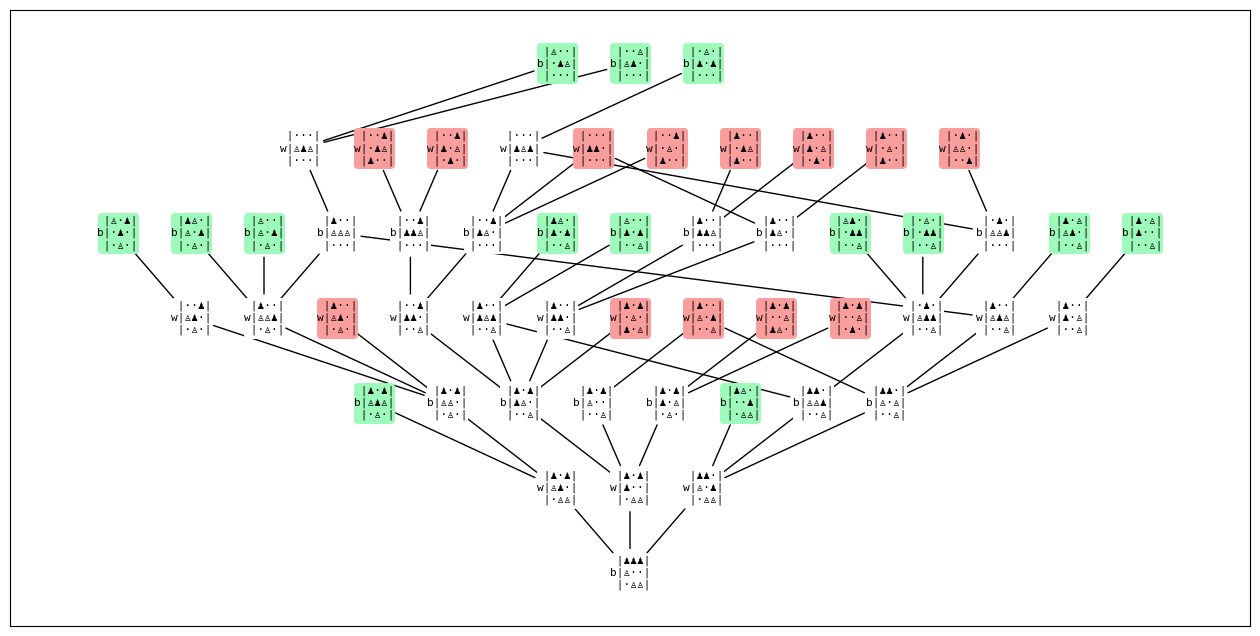

In [18]:
viz(subtrees['a1 a2'])


In [176]:
Game = tuple[int, list[tuple[Move, State, State]]]

# TODO: make the q-learner work on an appropriately filtered state space

@dataclass
class QLearner:
  """Reinforcement learning."""
  tree: GameTree
  player: int
  alpha = 0.9
  gamma = 0.999
  explore = 0.1
  q: dict[State, dict[Move, float]] | None = None

  def __post_init__(self):
    if self.q is None:
      self.q = {state: {move: 0.0 for move in state.moves}
                for state in self.tree.children}

  def max_q(self, state) -> float:
    if len(self.q[state]) == 0:
      return 0.0
    return max(self.q[state].values())

  def update(self, game: Game):
    for (move, state, next_state) in reversed(game):
      reward = float(next_state.winner == self.player)
      self.q[state][move] = (1 - self.alpha) * self.q[state][move]
      self.q[state][move] += self.alpha * (
          reward +  self.gamma * self.max_q(next_state))

  def move(self, state: State) -> Move:
    if random.random() < self.explore:
      return random.choice(state.moves)
    best_q = max(self.q[state].values())
    return random.choice([
        move for move, q in self.q[state].items()
        if q == best_q])

@dataclass
class Hexapawn:
  """A game of hexapawn.
  """
  tree: GameTree | None = None
  white_strategy: str = 'input'
  black_strategy: str = 'random'
  learner: dict[int, QLearner] | None = None
  record: Counter | None = None

  def __post_init__(self):
    if self.tree is None:
      self.tree = GameTree.rooted_at(State.initial())
    if self.record is None:
      self.record = Counter()
    self.strategy = {1: self.white_strategy, -1: self.black_strategy}
    self.learner = {
        +1: QLearner(self.tree, +1) if self.white_strategy == 'q' else None,
        -1: QLearner(self.tree, -1) if self.black_strategy == 'q' else None}

  def play(self, echo=None) -> Game:
    """Play a game of hexapawn.
    """
    if echo is None:
      echo = {'states', 'moves', 'winner'}
    state = self.tree.root
    game = []
    while not state.winner:
      if 'states' in echo: print('\n' + state.render_short())
      move = self.next_move(state)
      if 'moves' in echo: print(f'{PLAYER[state.to_play]} move: {move!s}')
      prev_state = state
      state = state.apply(move)
      game.append((move, prev_state, state))
    if 'states' in echo: print('\n' + state.render_short())
    if 'winner' in echo: print(f'{PLAYER[state.winner]} wins')
    return state.winner, game

  def next_move(self, state: State) -> Move | None:
    """Return the next move for the given state.
    """
    strat = self.strategy[state.to_play]
    learner = self.learner[state.to_play]
    match (strat):
      case 'q':
        return learner.move(state)
      case 'random':
        return self.random_move(state)
      case 'input':
        return self.input_move(state)
    raise ValueError(f'unknown strategy {strat}')

  def random_move(self, state: State) -> Move:
    """Return a random move.
    """
    return random.choice(state.moves)

  def input_move(self, state: State) -> Move:
    """Input a move for white.
    """
    def report_problem(move_str:str, issue: str):
      print(f'{issue} move "{move_str}"')
      print('your options are:', [str(m) for m in state.moves])
    move_str = input(f'{PLAYER[state.to_play]} move? ')
    try:
      move = Move.parse(move_str)
      if move not in state.moves:
        report_problem(move_str, 'illegal')
      return move
    except Exception as ex:
      report_problem(move_str, f'syntactically incorrect [{ex=}]')
    return self.input_move(state)

In [175]:
from tqdm import tqdm

def rwinner(h: Hexapawn, train=False):
  winner, game = h.play({})
  if train:
    for learner in h.learner.values():
      if learner is not None:
        learner.update(game)
  return winner

def score(h: Hexapawn, n = 10):
  return sum ([(rwinner(h, True) + 1) / 2 for _ in tqdm(range(n))]) / n

h = Hexapawn(white_strategy='random', black_strategy='q')
print('training', score(h, 100))
h.learner[-1].explore = 0
print('trained', score(h, 10000))

100%|██████████| 100/100 [00:00<00:00, 9734.50it/s]


training 0.27


100%|██████████| 10000/10000 [00:00<00:00, 11551.26it/s]

trained 0.1917
